# Code is from Kaggle -- https://www.kaggle.com/datasets/adilshamim8/nlp-task 🌻

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-task/movies_overview.csv
/kaggle/input/nlp-task/movies_genres.csv


# pips

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu
%pip install langdetect
%pip install transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

# Import libriaries

In [3]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import faiss
import requests
import langdetect
from langdetect import detect
from transformers import MarianMTModel, MarianTokenizer
import openai

2025-06-20 19:17:25.838954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750447046.016839      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750447046.066481      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Загружаем данные
df = pd.read_csv('/kaggle/input/nlp-task/movies_overview.csv')
genres_df = pd.read_csv('/kaggle/input/nlp-task/movies_genres.csv')

# Анализ данных 

In [5]:
df.head

<bound method NDFrame.head of                          title  \
0     The Shawshank Redemption   
1                The Godfather   
2        The Godfather Part II   
3             Schindler's List   
4                 12 Angry Men   
...                        ...   
9975             Double Dragon   
9976               The Fanatic   
9977                    SPF-18   
9978            Fantastic Four   
9979       Natale in Sudafrica   

                                               overview              genre_ids  
0     Imprisoned in the 1940s for the double murder ...               [18, 80]  
1     Spanning the years 1945 to 1955, a chronicle o...               [18, 80]  
2     In the continuing saga of the Corleone crime f...               [18, 80]  
3     The true story of how businessman Oskar Schind...        [18, 36, 10752]  
4     The defense and the prosecution have rested an...                   [18]  
...                                                 ...                    

In [6]:
genres_df.head

<bound method NDFrame.head of        id             name
0      28           Action
1      12        Adventure
2      16        Animation
3      35           Comedy
4      80            Crime
5      99      Documentary
6      18            Drama
7   10751           Family
8      14          Fantasy
9      36          History
10     27           Horror
11  10402            Music
12   9648          Mystery
13  10749          Romance
14    878  Science Fiction
15  10770         TV Movie
16     53         Thriller
17  10752              War
18     37          Western>

In [7]:
# проверим размеры
print(df.info())
print(genres_df.info())

# и пропуски
print(df.isna().sum())
print(genres_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9980 non-null   object
 1   overview   9980 non-null   object
 2   genre_ids  9980 non-null   object
dtypes: object(3)
memory usage: 234.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19 non-null     int64 
 1   name    19 non-null     object
dtypes: int64(1), object(1)
memory usage: 436.0+ bytes
None
title        0
overview     0
genre_ids    0
dtype: int64
id      0
name    0
dtype: int64


Пропусков в датасете нет, каждое поле заполнено

переименуем столбец в genres_df 'id' на идентичный в movies_overview -- genre_ids

In [8]:
genres_df.rename(columns={'id':'genre_ids'}, inplace=True)

In [9]:
genres_df

,genre_ids,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [10]:
# маппинг жанров
genre_map = dict(zip(genres_df['genre_ids'], genres_df['name']))

# Преобразуем список ID в список названий жанров
df['genre_names'] = df['genre_ids'].apply(lambda ids: [genre_map[i] for i in ids 
                                                       if i in genre_map])

# Обработка overview (на случай пропусков)
df['overview'] = df['overview'].fillna('')

# итоговый текст
df['text'] = df['overview'] + ' Жанры: ' + df['genre_names'].apply(lambda x: ', '.join(x))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


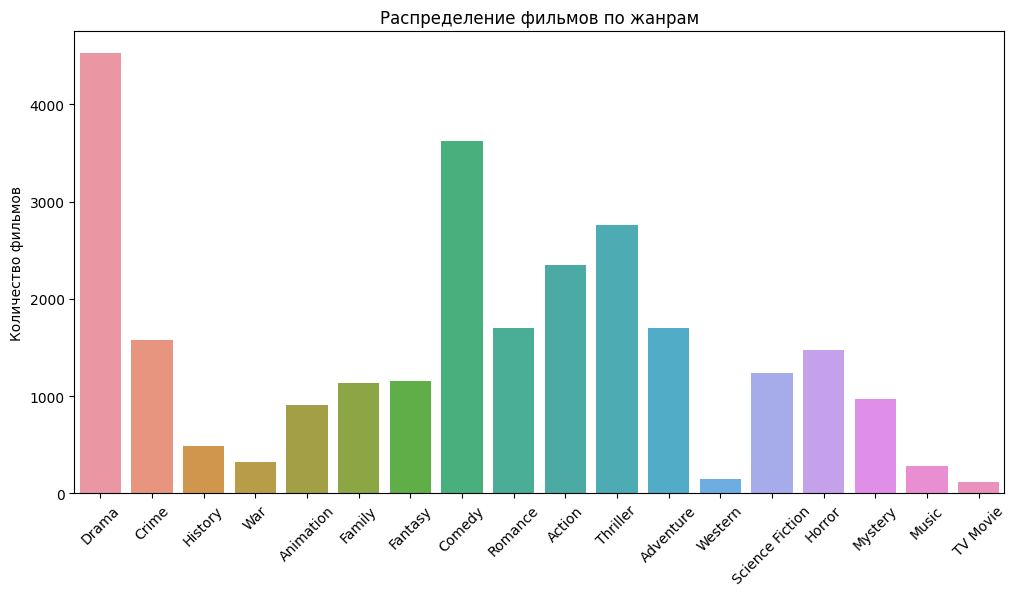

In [11]:
# Преобразуем строки с genre_ids в списки
df['genre_ids'] = df['genre_ids'].apply(ast.literal_eval)

# Собираем все жанры
all_genres = [genre_map[gid] for sublist in df['genre_ids'] for gid in sublist if gid in genre_map]

genre_counts = Counter(all_genres)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=45)
plt.title("Распределение фильмов по жанрам")
plt.ylabel("Количество фильмов")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


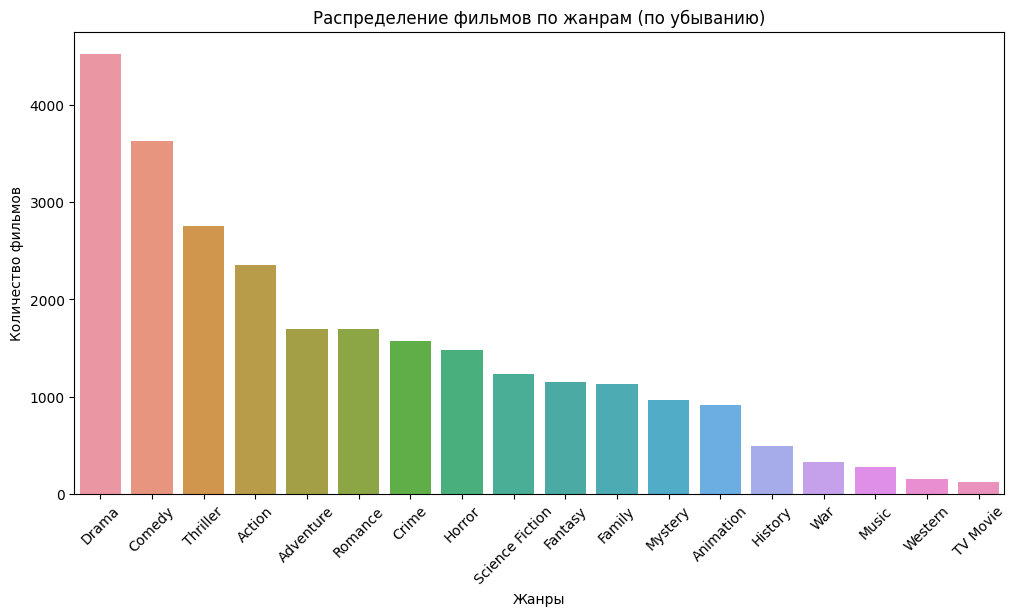

In [12]:
# Сортировка жанров по убыванию количества
sorted_genres = genre_counts.most_common()  # список кортежей (жанр, количество)

# Разделим на ключи и значения
genres, counts = zip(*sorted_genres)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(genres), y=list(counts))
plt.xticks(rotation=45)
plt.title("Распределение фильмов по жанрам (по убыванию)")
plt.ylabel("Количество фильмов")
plt.xlabel("Жанры")
plt.show()

In [13]:
# Считаем все жанры (каждый фильм может входить в несколько жанров)
all_genres = [genre_map[gid] for sublist in df['genre_ids'] 
              for gid in sublist 
              if gid in genre_map]
genre_counts = Counter(all_genres)

# Сортируем по убыванию
sorted_genres = genre_counts.most_common()

print("Жанры и количество фильмов:")
for i, (genre, count) in enumerate(sorted_genres, 1):
    print(f"{i}. {genre}: {count}")

Жанры и количество фильмов:
1. Drama: 4523
2. Comedy: 3626
3. Thriller: 2757
4. Action: 2349
5. Adventure: 1700
6. Romance: 1699
7. Crime: 1573
8. Horror: 1475
9. Science Fiction: 1235
10. Fantasy: 1154
11. Family: 1134
12. Mystery: 966
13. Animation: 910
14. History: 490
15. War: 324
16. Music: 279
17. Western: 152
18. TV Movie: 119


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

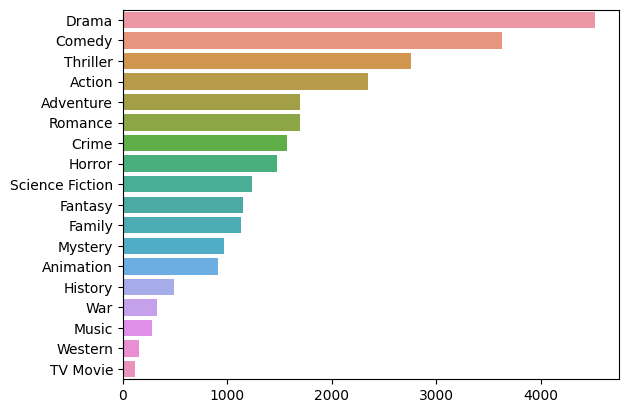

In [14]:
sns.barplot(y=list(genres), x=list(counts))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


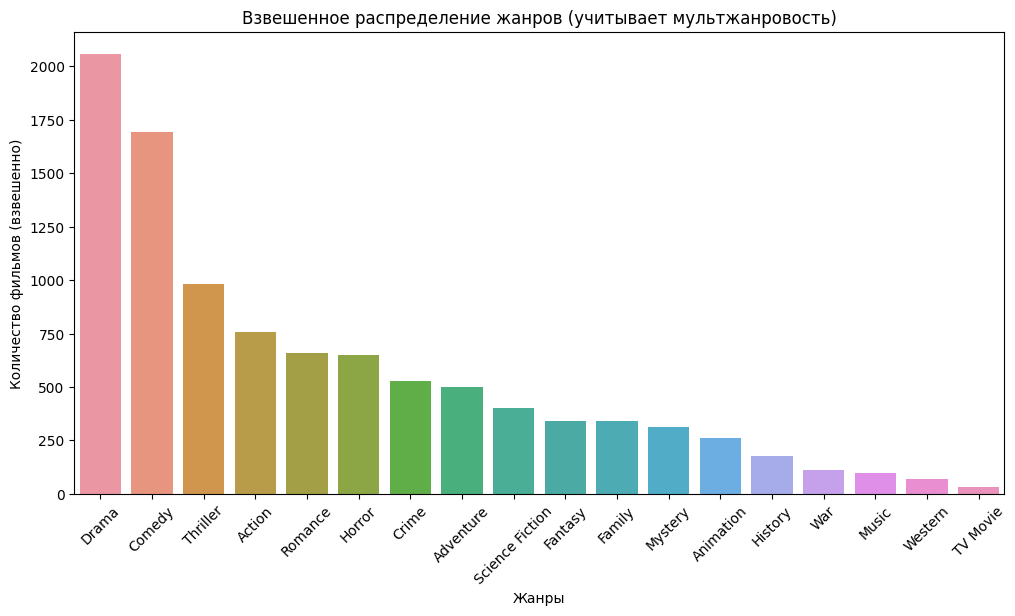

In [15]:
weighted_counts = defaultdict(float)

for genre_list in df['genre_ids']:
    valid_genres = [genre_map[gid] 
                    for gid in genre_list 
                    if gid in genre_map]
    weight = 1 / len(valid_genres) if valid_genres else 0
    for g in valid_genres:
        weighted_counts[g] += weight

sorted_weighted = sorted(weighted_counts.items(), key=lambda x: x[1], reverse=True)
genres, counts = zip(*sorted_weighted)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(genres), y=list(counts))
plt.xticks(rotation=45)
plt.title("Взвешенное распределение жанров (учитывает мультжанровость)")
plt.ylabel("Количество фильмов (взвешенно)")
plt.xlabel("Жанры")
plt.show()

In [16]:
# Словарь для подсчёта с накоплением весов
weighted_genre_counts = defaultdict(float)

# Проходим по всем фильмам
for genre_ids in df['genre_ids']:
    valid_genres = [genre_map[gid] for gid in genre_ids if gid in genre_map]
    if valid_genres:
        weight = 1 / len(valid_genres)
        for genre in valid_genres:
            weighted_genre_counts[genre] += weight

# Сортируем по убыванию
sorted_weighted = sorted(weighted_genre_counts.items(), key=lambda x: x[1], reverse=True)

# Выводим список
print("Взвешенное количество фильмов по жанрам:")
for i, (genre, weight) in enumerate(sorted_weighted, 1):
    print(f"{i}. {genre}: {weight:.2f}")

Взвешенное количество фильмов по жанрам:
1. Drama: 2058.62
2. Comedy: 1691.37
3. Thriller: 983.46
4. Action: 758.87
5. Romance: 657.26
6. Horror: 651.10
7. Crime: 528.96
8. Adventure: 500.18
9. Science Fiction: 400.47
10. Fantasy: 343.31
11. Family: 343.04
12. Mystery: 315.04
13. Animation: 259.66
14. History: 178.65
15. War: 109.51
16. Music: 97.06
17. Western: 68.35
18. TV Movie: 32.09


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


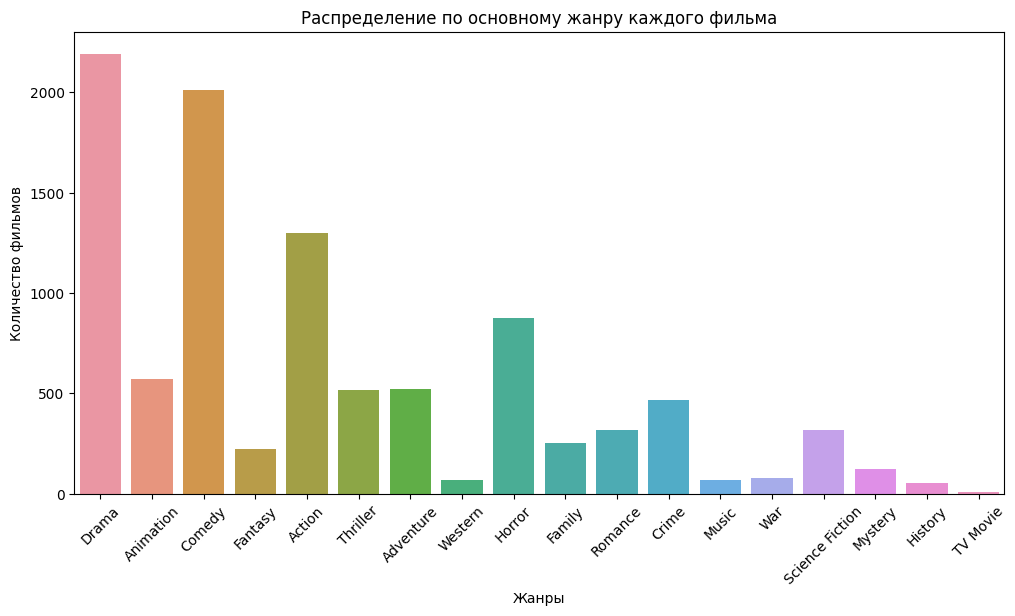

In [17]:
main_genres = [genre_map[gid_list[0]] for gid_list in df['genre_ids'] if gid_list and gid_list[0] in genre_map]
main_genre_counts = Counter(main_genres)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(main_genre_counts.keys()), y=list(main_genre_counts.values()))
plt.xticks(rotation=45)
plt.title("Распределение по основному жанру каждого фильма")
plt.ylabel("Количество фильмов")
plt.xlabel("Жанры")
plt.show()

Длина описаний фильма

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


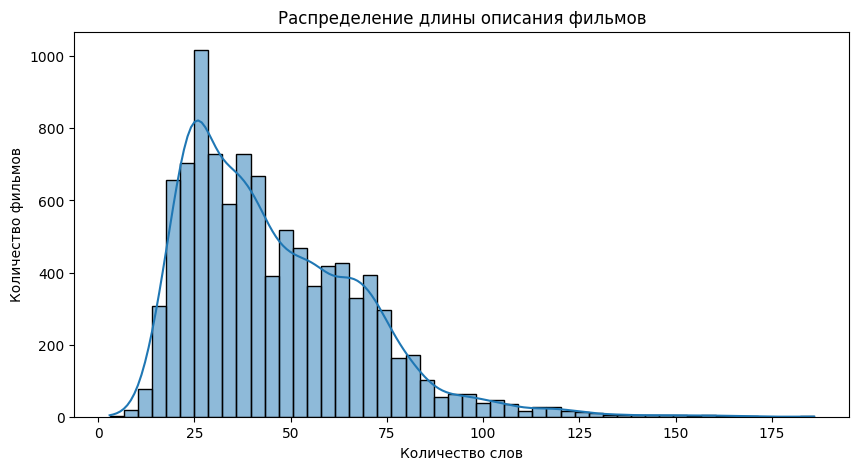

In [18]:
df['overview_length'] = df['overview'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['overview_length'], bins=50, kde=True)
plt.title("Распределение длины описания фильмов")
plt.xlabel("Количество слов")
plt.ylabel("Количество фильмов")
plt.show()

Объединение и создание текстового поля "контекста"

In [19]:
# смотрим типы элементов
print(df['genre_names'].apply(type).value_counts())

# смотрим примеры проблемных значений
print(df[df['genre_names'].apply(lambda x: not isinstance(x, list))]['genre_names'].head(10))

genre_names
<class 'list'>    9980
Name: count, dtype: int64
Series([], Name: genre_names, dtype: object)


In [20]:
# Фильтрация строк, где внутри списка есть не-строки
bad_rows = df[df['genre_names'].apply(lambda lst: any(not isinstance(i, str) for i in lst))]
print(bad_rows[['title', 'genre_names']].head())

Empty DataFrame
Columns: [title, genre_names]
Index: []


Предполагается, что:

df содержит: ['title', 'overview', 'genre_ids']

genres_df содержит: ['id', 'name']

df['genre_ids'] — это списки целых чисел

In [21]:
# Создаём отображение id → имя жанра
genre_map = dict(zip(genres_df['genre_ids'], genres_df['name']))

# Преобразуем жанры: id → имя (или 'Unknown', если id не найден)
df['genre_names'] = df['genre_ids'].apply(
    lambda ids: [genre_map.get(gid, 'Unknown') for gid in ids]
)

# Создаём колонку "text" с объединением описания и жанров
df['text'] = df['overview'] + ' Жанры: ' + df['genre_names'].apply(lambda x: ', '.join(x))

print(df[['title', 'text']].head())

                      title                                               text
0  The Shawshank Redemption  Imprisoned in the 1940s for the double murder ...
1             The Godfather  Spanning the years 1945 to 1955, a chronicle o...
2     The Godfather Part II  In the continuing saga of the Corleone crime f...
3          Schindler's List  The true story of how businessman Oskar Schind...
4              12 Angry Men  The defense and the prosecution have rested an...


In [22]:
df

,title,overview,genre_ids,genre_names,text,overview_length
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]","[Drama, Crime]",Imprisoned in the 1940s for the double murder ...,69
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]","[Drama, Crime]","Spanning the years 1945 to 1955, a chronicle o...",48
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]","[Drama, Crime]",In the continuing saga of the Corleone crime f...,39
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]","[Drama, History, War]",The true story of how businessman Oskar Schind...,29
4,12 Angry Men,The defense and the prosecution have rested an...,[18],[Drama],The defense and the prosecution have rested an...,58
...,...,...,...,...,...,...
9975,Double Dragon,Two brothers have half of a powerful ancient C...,"[28, 12, 35, 14, 878]","[Action, Adventure, Comedy, Fantasy, Science F...",Two brothers have half of a powerful ancient C...,36
9976,The Fanatic,A rabid film fan stalks his favorite action he...,"[80, 53]","[Crime, Thriller]",A rabid film fan stalks his favorite action he...,14
9977,SPF-18,18-year-old Penny Cooper spent years pining fo...,"[10749, 18]","[Romance, Drama]",18-year-old Penny Cooper spent years pining fo...,23
9978,Fantastic Four,Four young outsiders teleport to a dangerous u...,"[28, 12, 878]","[Action, Adventure, Science Fiction]",Four young outsiders teleport to a dangerous u...,42


In [23]:
# Отключить усечение вывода строк
pd.set_option('display.max_colwidth', None)

# Посмотреть первые строки
print(df[['title', 'text']].head(5))

                      title  \
0  The Shawshank Redemption   
1             The Godfather   
2     The Godfather Part II   
3          Schindler's List   
4              12 Angry Men   

                                                                                                                                                                                                                                                                                                                                                                                                                           text  
0  Imprisoned in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.

# Векторизация текстов

In [24]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Векторизуем все тексты
texts = df['text'].tolist()
embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

# Добавим эмбеддинги в DataFrame
df['embedding'] = list(embeddings)

print(f"Размерность эмбеддингов: {embeddings.shape}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/312 [00:00<?, ?it/s]

Размерность эмбеддингов: (9980, 384)


# Построение и использование индекса FAISS для быстрого поиска похожих фильмов

создаём индекс

In [25]:
# Размерность эмбеддингов
d = embeddings.shape[1]

# Создаём индекс с евклидовой метрикой (L2)
index = faiss.IndexFlatL2(d)

# Добавляем эмбеддинги
index.add(embeddings)

print(f"Индекс содержит {index.ntotal} элементов")

Индекс содержит 9980 элементов


поиск top-k похожих фильмов

In [26]:
def search_similar_movies(query, model, index, df, top_k=5):
    # Векторизуем запрос
    query_vec = model.encode([query], convert_to_numpy=True)

    # Ищем top_k соседей
    distances, indices = index.search(query_vec, top_k)

    results = []
    for dist, idx in zip(distances[0], indices[0]):
        movie = df.iloc[idx]
        results.append({
            'title': movie['title'],
            'overview': movie['overview'],
            'distance': dist
        })
    return results

# Пример использования + перевод вывода на русский

In [27]:
query = 'Детектив в заснеженной местности'
# query = 'car races'

In [28]:
def translate_text(text, src_lang, tgt_lang):
    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    batch = tokenizer([text], return_tensors="pt", padding=True)
    generated_ids = model.generate(**batch)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)


# какой язык запроса
query_lang = detect(query)

# Поиск похожих фильмов (на основе запроса, модели, индекса и df)
results = search_similar_movies(query, model, index, df, top_k=5)

for i, res in enumerate(results, 1):
    # Если запрос на русском, переводим overview
    overview_text = res['overview']
    if query_lang == 'ru':
        overview_text = translate_text(overview_text, 'en', 'ru')
    
    print(f"{i}. {res['title']} (distance: {res['distance']:.4f})")
    print(f"   {overview_text}\n")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

1. The Snowman (distance: 13.6228)
   Детектив Гарри Хоул расследует исчезновение женщины, чей розовый шарф был найден завернутым вокруг зловещего снеговика.



model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

2. 6 Below: Miracle on the Mountain (distance: 14.1959)
   Адреналин, ищущий сноубордиста, теряется в мощной зимней буре в задней части Сьерры, где его толкают до пределов человеческой стойкости и заставляют сражаться со своими собственными демонами, когда он борется за выживание...

3. The Dark Valley (distance: 14.8567)
   Грейдер, загадочный одинокий наездник, который утверждает, что он фотограф, прибывает в изолированную деревушку пиломатериалов, деспотично управляемую семейным кланом, с просьбой о зимнем жилье.

4. Knick Knack (distance: 15.9159)
   Жизнь на полке, как снеговик, застрявший в снежном метельце, может одеться, особенно когда вы окружены никкнаками из солнечных мест, когда снежный человек наконец-то освободится от своего стеклянного дома, его планы на отпуск будут сокращены.

5. 21 Bridges (distance: 15.9723)
   Детектив полиции Нью-Йорка, втянутый в общегородскую охоту за парой убийц-полицейских после того, как он раскрыл огромный и неожиданный заговор.



In [29]:
df.to_pickle("movies_with_embeddings.pkl")